In [1]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge the customer and transaction data on CustomerID
merged_data = pd.merge(transactions_df, customers_df, on='CustomerID', how='left')

# Aggregate data by CustomerID to create the customer profile
customer_features = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'nunique'),
    avg_spend_per_transaction=('TotalValue', 'mean'),
    region=('Region', 'first')
).reset_index()

# Add demographic features like signup duration
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
customers_df['SignupDuration'] = (pd.to_datetime('today') - customers_df['SignupDate']).dt.days

customer_features = pd.merge(customer_features, customers_df[['CustomerID', 'SignupDuration']], on='CustomerID')


In [2]:
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
X = customer_features[['total_spent', 'transaction_count', 'avg_spend_per_transaction', 'SignupDuration']]

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


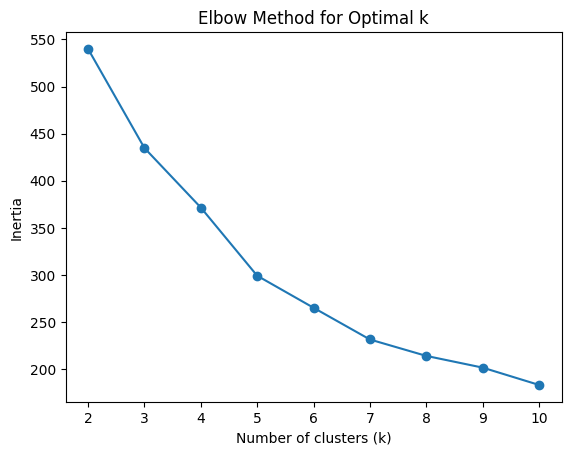

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Try clustering for different values of k
inertia = []  # To store the sum of squared distances for each k

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph to help determine the best k
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()


In [4]:
from sklearn.metrics import davies_bouldin_score

# Apply K-Means with the chosen number of clusters (e.g., k=4)
k = 4  # Assuming k=4 from the elbow method
kmeans = KMeans(n_clusters=k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

# Calculate the Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(X_scaled, customer_features['Cluster'])
print(f'Davies-Bouldin Index for k={k}: {db_index}')


Davies-Bouldin Index for k=4: 1.1612210862676202


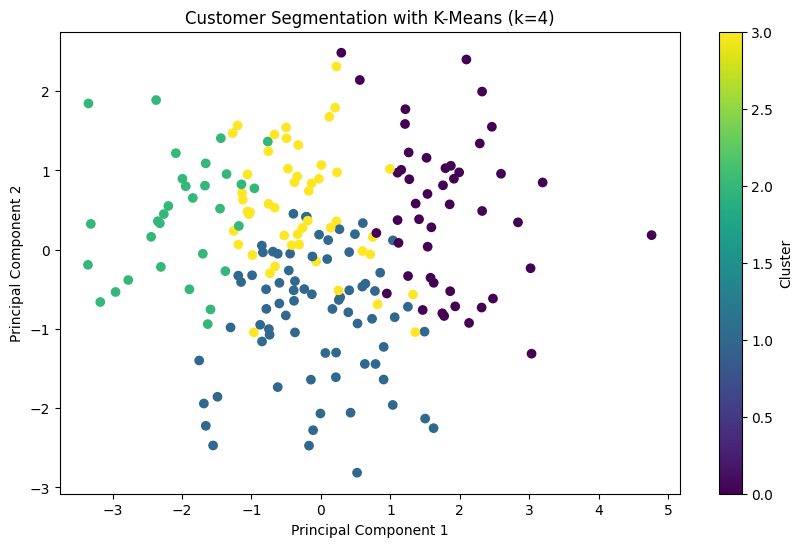

In [5]:
from sklearn.decomposition import PCA

# Reduce the dimensionality to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=customer_features['Cluster'], cmap='viridis')
plt.title(f'Customer Segmentation with K-Means (k={k})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()
